In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Code
## Aim
In order to boost the revenue of social media ads the marketing department wants to improve the product selection for advertisements on social media. Currently, the products are randomly selected. Therefore, we will create different recommendation systems, which should help to predict which product the user will like. The degree of personalisation depends on whether the user is already a customer and whether we can identify him as such at all. 
* For unknown users, the most popular products should be displayed.
* For users who have already clicked on an ad, similar products should be advertised in the future. (Content-based filtering)
* Known users should be recommended products based on their purchase history and that of similar users. (Collaborative filtering)

## Data
The dataset is from kaggle: https://www.kaggle.com/vijayuv/onlineretail. We will use the **already preprocessed data** from our clustering case. It includes the following values:

* CustomerID: Customer number assigned to each customer.
* InvoiceNo: Invoice Number assigned to each order. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code assigned to each product.
* Description: Product name.
* Quantity: Amount of each each product (item) per transaction.
* InvoiceDate: Date, where order was made. 
* UnitPrice: Price of a single product.
* Country: Country, where each customer resides.
* Total Sum: Quantity * UnitPrice for each product
* Cluster: segment of the customer


# Import data

In [3]:
df = pd.read_csv('../Recommender_Marketing.csv', delimiter=',', encoding = 'unicode_escape')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   397884 non-null  int64  
 1   InvoiceNo    397884 non-null  int64  
 2   StockCode    397884 non-null  object 
 3   Description  397884 non-null  object 
 4   Quantity     397884 non-null  int64  
 5   InvoiceDate  397884 non-null  object 
 6   UnitPrice    397884 non-null  float64
 7   Country      397884 non-null  object 
 8   TotalSum     397884 non-null  float64
 9   Cluster      336802 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 30.4+ MB


## First look into the data
The data contains 397884 rows. Each row stands for one product of an order. Orders can be grouped by InvoiceNo, customers by CustomerID and products by StockCode. As we can already see there are less entries in the Cluster column which indicates that there are missing values.

In [4]:
#first look into the data
df.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalSum,Cluster
0,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,77183.6,NaN
1,12347,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,25.2,2.0
2,12347,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,17.0,2.0
3,12347,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,39.0,2.0
4,12347,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,23.4,2.0


In [5]:
df.nunique()

CustomerID      4338
InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
Country           37
TotalSum        2810
Cluster            3
dtype: int64

In [6]:
df.describe()

,CustomerID,InvoiceNo,Quantity,UnitPrice,TotalSum,Cluster
count,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,336802.000000
mean,15294.423453,560616.934451,12.988238,3.116488,22.397000,1.106371
std,1713.141560,13106.117773,179.331775,22.097877,309.071041,0.961927
min,12346.000000,536365.000000,1.000000,0.001000,0.001000,0.000000
25%,13969.000000,549234.000000,2.000000,1.250000,4.680000,0.000000
50%,15159.000000,561893.000000,6.000000,1.950000,11.800000,2.000000
75%,16795.000000,572090.000000,12.000000,3.750000,19.800000,2.000000
max,18287.000000,581587.000000,80995.000000,8142.750000,168469.600000,2.000000


In [7]:
print("Total number of orders:", len(np.unique(df['InvoiceNo'])))
print("Total number of users:", len(np.unique(df['CustomerID'])))
print("Total number of products:", len(np.unique(df['StockCode'])))

Total number of orders: 18532
Total number of users: 4338
Total number of products: 3665


## Initial findings
* The *UnitPrice* for a product is relatively low and has some outliers on the right side of the distribution. Same applies to *TotalSum*.
* There are 18532 orders from 4338 different customers. We have 3665 different products.
* The *Description* texts are all in capital letters, which needs further preprocessing in our recommendation system 2.
* There are less entries in the *Cluster* column which indicates missing values, which we will need to take care of.

# Data Preprocessing
## Check missing values
As we already preprocessed the data in the clustering use case, all NA-values were already dropped. However, the cluster-information is missing for some customers who dropped out during the preparation of the rfm-Framework. As our recommendation systems won't use the column we can include the entries.

In [8]:
df.isnull().sum()

CustomerID         0
InvoiceNo          0
StockCode          0
Description        0
Quantity           0
InvoiceDate        0
UnitPrice          0
Country            0
TotalSum           0
Cluster        61082
dtype: int64

## Change datatypes

In [9]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['CustomerID']=df['CustomerID'].astype('category')
df['InvoiceNo']=df['InvoiceNo'].astype('category')
df['StockCode']=df['StockCode'].astype('category')
df['Description']=df['Description'].astype('category')
df['Country']=df['Country'].astype('category')
df['Cluster']=df['Cluster'].astype('category')

## Create dictionary with StockCode and Description

In [10]:
#create dictionary for later checks
items =dict(zip(df.StockCode, df.Description))

# Recommendation System 1: Most popular products
One way to systematically select products is to rank the products based on how many times they were sold. In this way, we can identify the 20 most popular products and recommend them to all our customers. We will test our definition of most popular products on the CustomerID (How many customers have bought the item?) and the Quantity (How many times was the item bought?) features. Then we will see which one of them is more suitable for the definition of popular products. 

In [11]:
# most popular products: customer- and quantity-based
popular=df.groupby(['StockCode']).agg({
    'CustomerID': 'count',
    'Quantity':'sum'})


In [12]:
#Most popular products by Quantity
popular.sort_values(by=['Quantity'], ascending=False).head(10)

,CustomerID,Quantity
StockCode,,
23843,1,80995
23166,198,77916
84077,473,54415
22197,1068,49183
85099B,1618,46181
85123A,2035,36782
84879,1408,35362
21212,1068,33693
23084,842,27202


In [13]:
#Most popular products by Quantity
popular.sort_values(by=['CustomerID'], ascending=False).head(10)

,CustomerID,Quantity
StockCode,,
85123A,2035,36782
22423,1723,12402
85099B,1618,46181
84879,1408,35362
47566,1396,15291
20725,1317,17897
22720,1159,7020
20727,1105,11291
POST,1099,3120


The sorted values reveal that there are individual customers who buy a very large quantity of a product. Since there preference cannot be assumed for the entire customer base, we define the most popular products depending on how many customers have already bought the product.

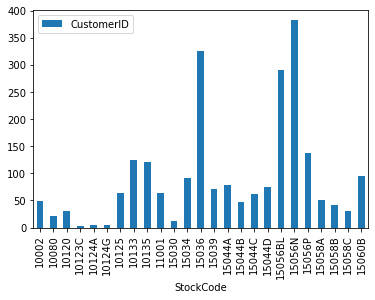

In [14]:
popular.head(25).plot(kind = "bar", y='CustomerID')

# Recommendation System 2: Item-to-Item based recommendation
Even though our first system is already better than a random product selection, it offers all customers the same products and doesn't leverage existing information about the user. If an user has already clicked on a social media ad and accepts the cookies, we can identify him again. Therefore, we can recommend products similar to the one's he has already viewed.

## Define dataset
To identify similar products we will use the *Description* and *StockCode* feature.

In [89]:
df.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalSum,Cluster
0,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,77183.6,NaN
1,12347,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,25.2,2.0
2,12347,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,17.0,2.0
3,12347,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,39.0,2.0
4,12347,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,23.4,2.0


In [90]:
#drop unnecessary columns
df_reco2=df.drop(['CustomerID','InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'TotalSum', 'Country', 'Cluster'], axis=1)

In [91]:
#only one row for each product
df_reco2=df_reco3.drop_duplicates()

In [92]:
df_reco2.head()

,StockCode,Description
0,23166,MEDIUM CERAMIC TOP STORAGE JAR
1,85116,BLACK CANDELABRA T-LIGHT HOLDER
2,22375,AIRLINE BAG VINTAGE JET SET BROWN
3,71477,COLOUR GLASS. STAR T-LIGHT HOLDER
4,22492,MINI PAINT SET VINTAGE


## Prepare Description column
<p style='color:red'>Wieso funktioniert löschen von Satzzeichen nicht?Noch weitere Tips für Preprocessing?</p>

In [93]:
#regular expressiond, z.B. nur noch Buchstaben
#lower description and delete all punctuation marks
df_reco2['Description']=df_reco2['Description'].str.lower()
df_reco2['Description']=df_reco2['Description'].replace(".", " ")

In [94]:
df_reco2.head()

,StockCode,Description
0,23166,medium ceramic top storage jar
1,85116,black candelabra t-light holder
2,22375,airline bag vintage jet set brown
3,71477,colour glass. star t-light holder
4,22492,mini paint set vintage


## Create Tfidf Matrix from product description
Tf-Idf-Vectorizer transforms text to feature vectors. It converts each word/token to a feature index in the matrix. Additionally, it takes into account the relevance of each term based on how many times it occurs in the text. Words that occur less frequently are given a higher value than words that occur very frequently, because they can be used to identify a single product with a higher probability.

In [95]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
#create tfidf-matrix: Product description is broken down into words. Each word becomes a column and receives value in row, where it occurs
tfidf_matrix = tf.fit_transform(df_reco2['Description'])

With the *linear_kernel()*-Funktion we can calculate the cosinus-simularity between the products. The cosinus simularity considers the angle between to vectors. The higher the value, the more similar are the vectors. 

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

As linear kernel compares each products with all of the others, it results in an array, which contains a list of all simularity measures for each product. This list is ordered by their sequence in the matrix. For example Product 1 is 100% similar to product 1 as it is the same.

In [112]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Build recommendation function
We now have the information how similar each product description is compared to another. Therefore, we can build a function, which orders the recommended products based on how similar they are to the original product. In other words: We rank the products in descending order of cosinus similarity.

In [98]:
# Build a 1-dimensional array with description
description = df_reco2['Description']
indices = pd.Series(df_reco2.index, index=df_reco2['Description'])

# Function that get book recommendations based on the cosine similarity score of book authors
def item_recommendation(product):
    # get index of product
    idx = indices[product]
    # get all cosinus similarities of the product
    sim_scores = list(enumerate(cosine_sim[idx]))
    #sort cosinus similarity in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #limit to top 20 most similar
    sim_scores = sim_scores[1:21]
    # get id for recommended products in order to get their description names
    item_indices = [i[0] for i in sim_scores]
    return description.iloc[item_indices]

In [114]:
#testing the function
item_recommendation('airline bag vintage jet set brown')

62            airline bag vintage jet set red
37          airline bag vintage jet set white
109       airline bag vintage world champion 
63               airline bag vintage tokyo 78
4340             jumbo bag vintage christmas 
806                    jumbo bag vintage leaf
1230                 jumbo bag vintage doily 
1158                 lunch bag vintage doily 
164018              jumbo bag vintage doiley 
194811              lunch bag vintage doiley 
395           charlotte bag vintage alphabet 
4859                cabin bag vintage paisley
1231              cabin bag vintage retrospot
784             lunch bag vintage leaf design
10888       cosmetic bag vintage rose paisley
1089            wash bag vintage rose paisley
10008      overnight bag vintage rose paisley
205411       weekend bag vintage rose paisley
11498               airline lounge,metal sign
179215          classic diamante earrings jet
Name: Description, dtype: object

# Recommendation system 3: Collaborative filtering based on purchase history and cluster
If we can clearly identify a customer, we can personalise the ad even more. We can consider their purchasing history as well as how much they liked the product.

## Create dataframe
We will base the recommender on the *CustomerID* and *StockCode* and *Quantity* feature. In this way, we see who bought what product and we use *Quantity* as an indicator of how much the customer liked the product. 

In [137]:
df.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalSum,Cluster
0,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,77183.6,NaN
1,12347,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,25.2,2.0
2,12347,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,17.0,2.0
3,12347,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,39.0,2.0
4,12347,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,23.4,2.0


In [138]:
#drop unnecessary columns
df_reco3=df.drop(['InvoiceNo', 'InvoiceDate', 'Cluster', 'Description', 'UnitPrice', 'TotalSum', 'Country'], axis=1)

In [139]:
#drop rows with missing values
df_reco3=df_reco3.dropna()

In [140]:
df_reco3.head()

,CustomerID,StockCode,Quantity
0,12346,23166,74215
1,12347,85116,12
2,12347,22375,4
3,12347,71477,12
4,12347,22492,36


## Create Matrix
The utility_matrix shows all which items each user has bought. Products are listed in columns, customers in rows and the quantity is in the cell of the product bought by a customer. Most values are unknown as one singluar customer doesn't buy nearly all different products.

In [141]:
cluster_utility_matrix = df_reco3.pivot_table(values='Quantity', index='CustomerID', columns='StockCode', aggfunc='first', fill_value=0)
cluster_utility_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [142]:
cluster_utility_matrix.shape

(4338, 3665)

The shape reveals again our 4288 customers and 3626 different products.

## Switch columns and rows
In the next step, we will transpose the matrix, which means we swith columns and rows.

In [143]:
#Transposing the matrix
X = cluster_utility_matrix.T
X.head()

CustomerID,12346,12347,12348,12349,12350,12352,12353,12354,12355,12356,...,18273,18274,18276,18277,18278,18280,18281,18282,18283,18287
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10123C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10124A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature reduction
As we have a third dimension with the quantity-column, we have to perform a feature reduction. This means we recreate the utility matrix with 2 instead of 3 components. Therefore, we will use SVD (Singular Value Decomposition), which reduces the number of features of a dataset by extracting its latent factors. This mapping facilitates a clear representation of relationships between users and items. 

In [144]:
#Decomposing the matrix
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(3665, 10)

To determine the similarity of users, we will use pearson correlation coefficient and create a correlation matrix. It calculates the correlation between every single customer and all users, who have bought at least one same product like our target user. The correlation with other user's is 0. Once we have these values, we can recommend products based on the purchasing behavior of similar customers.

In [145]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(3665, 3665)

## Example
We randomly choose one product, which was bought by a customer to see what other products similar users bought and what items we should recommend. 

In [158]:
#randomly choose a product
#save StockCode in Variable
i = X.index[99]

# Save the chosen product_id in variable
product_ID=99

#print StockCode
print(i)

'17096'

In [160]:
#correlation of all items with the chosen item/user
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(3665,)

In [161]:
#Rank correlated products for the item in descending order
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

#Print 10 most correlated items
Recommend[0:9]

['10135',
 '15030',
 '15036',
 '15039',
 '15044A',
 '15044D',
 '15058C',
 '16008',
 '16015']

In [163]:
print ('Product bought: ', items['17096'])
print ('Recommended products: ')
#print product description to StockCodes
for x in Recommend[0:9]:
    print(items[x])

Product bought:  ASSORTED LAQUERED INCENSE HOLDERS
Recommended products: 
COLOURING PENCILS BROWN TUBE
FAN BLACK FRAME 
ASSORTED COLOURS SILK FAN
SANDALWOOD FAN
PINK PAPER PARASOL 
RED PAPER PARASOL
ICE CREAM DESIGN GARDEN PARASOL
SMALL FOLDING SCISSOR(POINTED EDGE)
MEDIUM CHINESE STYLE SCISSOR


# Conclusion

Based on the purchase history of our clients, we were able to build 3 different recommenders to optimise our social media ads. 
* For the recommender systems to be successful, it is essential, that the recommenders are **connected to current data sources** and update automatically. Only in this way, new products or a change in buying behaviour can be included in the recommendation.
* In order to be able to address the customer individually, it is important that we can **clearly identify** him or her. This is the basic requirement for Recommender system 3. 
* The lack of mapping is known as the cold start problem.  Even if the degree of personalisation is lower, Recommender system 2 and 1 form a solid **fallback solution to counteract this problem**. We can either show customers similar products to those they have already seen or draw their attention to our most popular products.